In [5]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as trans_f
import torch.nn.functional as nn_f


sys.path.append(os.path.abspath(sys.path[0] + '/../../'))
__package__ = "deep_view_syn.notebook"
torch.cuda.set_device(2)
print("Set CUDA:%d as current device." % torch.cuda.current_device())

from ..data.spherical_view_syn import *
from ..msl_net import MslNet
from ..configs.spherical_view_syn import SphericalViewSynConfig
from ..my import netio
from ..my import util
from ..my import device
from ..my import view


os.chdir(sys.path[0] + '/../data/sp_view_syn_2020.12.31_fovea')
print('Change working directory to ', os.getcwd())
torch.autograd.set_grad_enabled(False)

Set CUDA:2 as current device.
Change working directory to  /home/dengnc/deep_view_syn/data/sp_view_syn_2020.12.31_fovea


In [5]:
# Load Config
config = SphericalViewSynConfig()
config.load_by_name('msl_coarse_gray1')
config.SAMPLE_PARAMS['spherical'] = True
config.SAMPLE_PARAMS['perturb_sample'] = False
config.print()

# Load Dataset
view_dataset = SphericalViewSynDataset('train.json', load_images=True, load_depths=False, gray=True)
print('View dataset loaded.')
def read_ref_images(idx):
    patt= 'ref/train/view_%04d.png'
    if isinstance(idx, torch.Tensor) and len(idx.size()) > 0:
        return trans_f.rgb_to_grayscale(util.ReadImageTensor([patt % i for i in idx]))
    else:
        return trans_f.rgb_to_grayscale(util.ReadImageTensor(patt % idx))
print('Ref dataset loaded.')

indices = torch.arange(view_dataset.n_views, device=device.GetDevice()).view(view_dataset.samples)
cam_params = view_dataset.cam_params
lr_cam_params = view.CameraParam({
    "fov" : 10,
    "cx" : 25.0,
    "cy" : 25.0
}, (50, 50)).to(device.GetDevice())
ref_cam_params = view.CameraParam({
    "fx" : 519.615251596838,
    "fy" : -519.615251596838,
    "cx" : 300.0,
    "cy" : 300.0
}, (600, 600)).to(device.GetDevice())
gt_images = view_dataset.view_images
gt_depths = view_dataset.view_depths
rays_o = view_dataset.rays_o
rays_d = view_dataset.rays_d
views_o = view_dataset.view_centers
views_r = view_dataset.view_rots

# Load Spher net
net = MslNet(config.FC_PARAMS, config.SAMPLE_PARAMS, gray=True, encode_to_dim=config.N_ENCODE_DIM).to(device.GetDevice())
netio.LoadNet('msl_coarse_gray1_b4096/model-epoch_500.pth', net)
print('Net loaded.')

def plot_point_cloud(pcloud, colors, ax=None):
    if not ax:
        plt.figure(figsize=(12, 12))
        ax = plt.gca(projection='3d')
    points3 = pcloud.flatten(0, -2).cpu().numpy()
    colors = colors.permute(1, 2, 0).flatten(0, 1).expand(-1, 3).cpu().numpy()
    ax.scatter(points3[:, 0], points3[:, 2], points3[:, 1], color=colors, s=0.3)
    util.save_2d_tensor('points.csv', points3)
    util.save_2d_tensor('colors.csv', colors)

==== Config msl_coarse_gray1 ====
Net type:  msl
Encode dim:  10
Full-connected network parameters: {'nf': 64, 'n_layers': 12, 'skips': []}
Sample parameters {'depth_range': (1, 20), 'n_samples': 16, 'perturb_sample': False, 'spherical': True}
Loss mse
View dataset loaded.
Ref dataset loaded.
Load net from msl_coarse_gray1_b4096/model-epoch_500.pth ...
Net loaded.


In [39]:
from torchvision.utils import save_image

center_view_coord: (1, 1, 1, 4, 1)
center_view_idx: tensor(364, device='cuda:2')
bound_view_idxs: [tensor(200, device='cuda:2'), tensor(692, device='cuda:2'), tensor(36, device='cuda:2'), tensor(528, device='cuda:2')]
o: torch.Size([3]) tensor([0., 0., 0.], device='cuda:2')
r: torch.Size([3, 3]) tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:2')
center_rays_o: torch.Size([100, 100, 3]) tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0

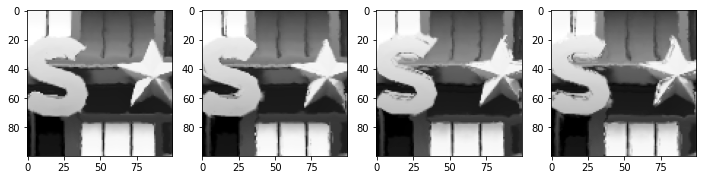

bounds_diff: torch.Size([1, 1, 600, 600])


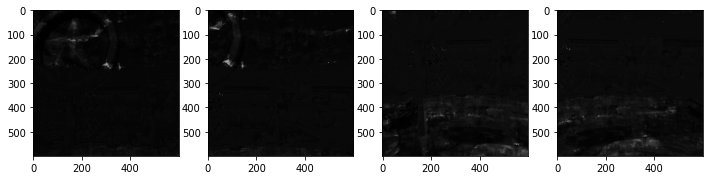

input_refined: torch.Size([1, 1, 100, 100])
avg_diff: torch.Size([1, 1, 100, 100]) tensor([[[[ 0.0244,  0.0215,  0.0161,  ..., -0.0688, -0.1160, -0.1642],
          [ 0.0218,  0.0196,  0.0184,  ..., -0.0104, -0.0453, -0.1663],
          [ 0.0138,  0.0167,  0.0179,  ...,  0.0410,  0.0224, -0.1608],
          ...,
          [-0.2267, -0.3315, -0.2233,  ..., -0.1219, -0.0713,  0.0251],
          [-0.2057, -0.2730, -0.0660,  ..., -0.1196, -0.0640,  0.1708],
          [-0.1603, -0.3205,  0.0034,  ..., -0.1522, -0.0462,  0.1863]]]],
       device='cuda:2')
warped_diff: torch.Size([1, 1, 100, 100])


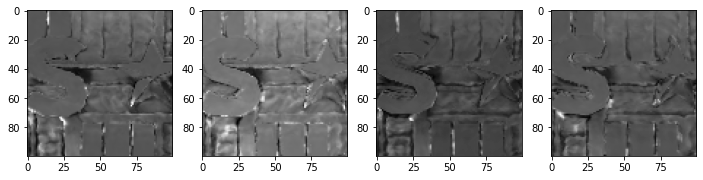

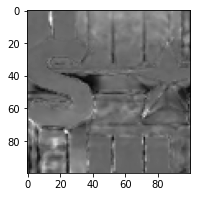

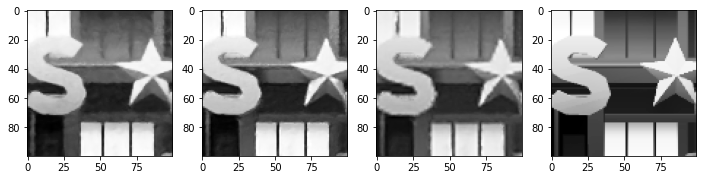

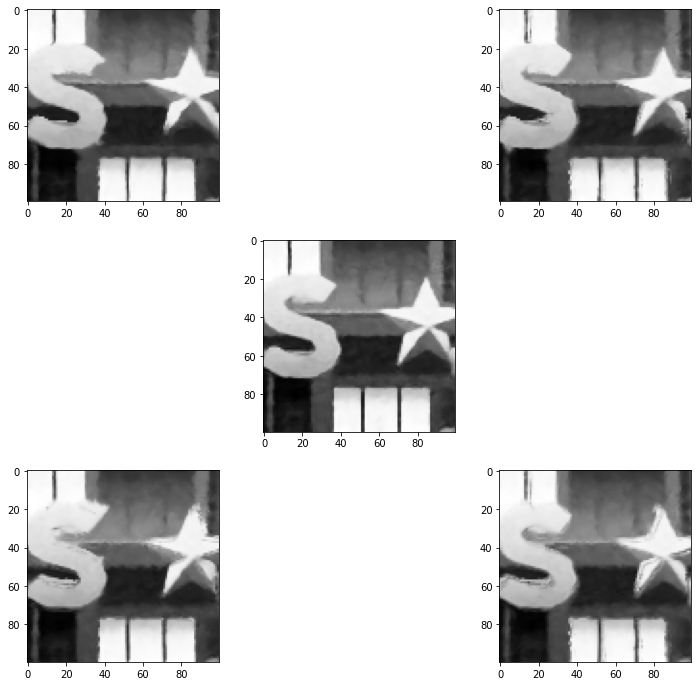

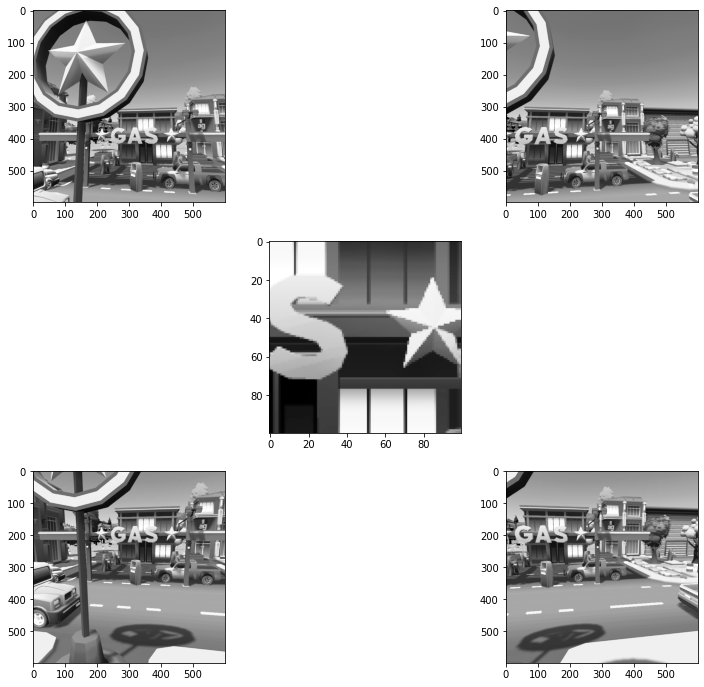

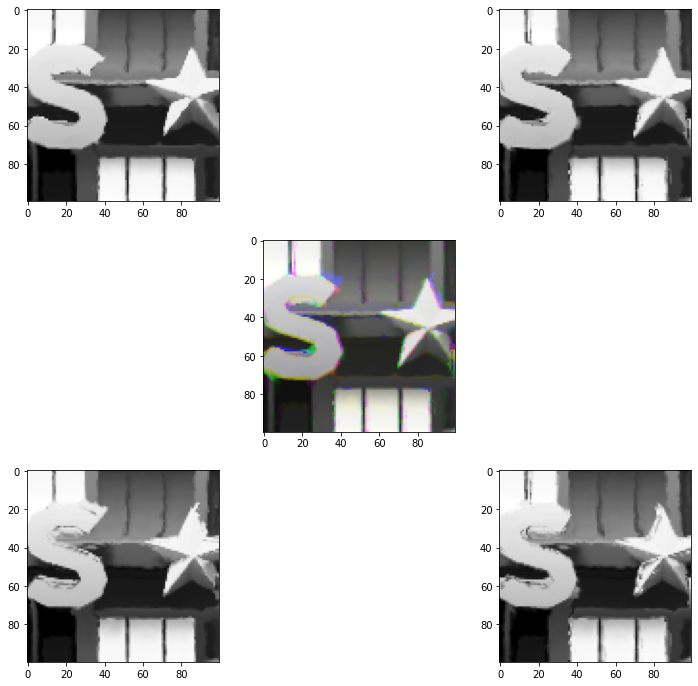

In [40]:
def get_warp (rays_o, rays_d, depthmap, tgt_o, tgt_r, tgt_cam):
    pcloud = rays_o + rays_d * depthmap[..., None]
    pcloud_in_tgt = view.trans_point(
        pcloud, tgt_o, tgt_r, inverse=True)[None, ...]
    pixel_positions = tgt_cam.proj(pcloud_in_tgt)
    pixel_positions[..., 0] /= ref_cam_params.res[1] * 0.5
    pixel_positions[..., 1] /= ref_cam_params.res[0] * 0.5
    pixel_positions -= 1
    return pixel_positions


center_view_coord = tuple(val // 2 for val in view_dataset.samples)
print("center_view_coord:",center_view_coord)
center_view_idx = indices[center_view_coord]
print("center_view_idx:",center_view_idx)
bound_view_idxs = [
    indices[center_view_coord[0] - 1, center_view_coord[1] + 1, center_view_coord[2],
            center_view_coord[3] - 1, center_view_coord[4] + 1],
    indices[center_view_coord[0] + 1, center_view_coord[1] + 1, center_view_coord[2],
            center_view_coord[3] + 1, center_view_coord[4] + 1],
    indices[center_view_coord[0] - 1, center_view_coord[1] - 1, center_view_coord[2],
            center_view_coord[3] - 1, center_view_coord[4] - 1],
    indices[center_view_coord[0] + 1, center_view_coord[1] - 1, center_view_coord[2],
            center_view_coord[3] + 1, center_view_coord[4] - 1]
]
print("bound_view_idxs:",bound_view_idxs)
#bound_view_idxs = [
#    indices[center_view_coord[0], center_view_coord[1], center_view_coord[2],
#            center_view_coord[3] - 1, center_view_coord[4]],
#    indices[center_view_coord[0], center_view_coord[1], center_view_coord[2],
#            center_view_coord[3] + 1, center_view_coord[4]],
#]
o = views_o[center_view_idx]
r = views_r[center_view_idx]
center_rays_o = rays_o[center_view_idx]
center_rays_d = rays_d[center_view_idx]
print("o:",o.shape,o)
print("r:",r.shape,r)
print("center_rays_o:",center_rays_o.shape,center_rays_o)
print("center_rays_d:",center_rays_d.shape,center_rays_d)
lr_center_rays_o = o[None, None, :].expand(lr_cam_params.res[0], lr_cam_params.res[1], -1)
lr_center_rays_d = view.trans_vector(lr_cam_params.get_local_rays(), r)
input, depthmap_ = net(center_rays_o, center_rays_d, ret_depth=True)
print("input:",input.shape,input)
print("depthmap:",depthmap_.shape,depthmap_)
lr_input, lr_depthmap = net(lr_center_rays_o, lr_center_rays_d, ret_depth=True)
print(lr_input.size(), lr_depthmap.size())
lr_input = nn_f.upsample(lr_input[None, ...], scale_factor=2, mode='bicubic')[0]
lr_depthmap = nn_f.upsample(lr_depthmap[None, None, ...], scale_factor=2, mode='bicubic')[0, 0]
gt = gt_images[center_view_idx]
bounds_img = [read_ref_images(idx).to(device.GetDevice())
              for idx in bound_view_idxs]
bounds_o = [views_o[idx] for idx in bound_view_idxs]
bounds_r = [views_r[idx] for idx in bound_view_idxs]
bounds_rays_o = [
    views_o[idx][None, None, :].expand(ref_cam_params.res[0], ref_cam_params.res[1], -1)
    for idx in bound_view_idxs
]
bounds_rays_d = [
    view.trans_vector(ref_cam_params.get_local_rays(), views_r[idx])
    for idx in bound_view_idxs
]
bounds_inferred = [
    net(bounds_rays_o[i], bounds_rays_d[i])[None, ...]
    for i in range(len(bounds_img))
]
bounds_diff = [
    (bounds_img[i] - bounds_inferred[i] + 1e-5) / (bounds_inferred[i] + 1e-5)
    for i in range(len(bounds_img))
]
bounds_warp = [
    get_warp(center_rays_o, center_rays_d, depthmap_, bounds_o[i], bounds_r[i], ref_cam_params)
    for i in range(len(bounds_img))
]
print("bounds_warp:",len(bounds_warp),bounds_warp[0].shape,bounds_warp[0])

bounds_warp_lr = [
    get_warp(center_rays_o, center_rays_d, lr_depthmap, bounds_o[i], bounds_r[i], ref_cam_params)
    for i in range(len(bounds_img))
]

def refine(input, bounds_diff, warps):
    warped_diff = [nn_f.grid_sample(bounds_diff[i], warps[i]) for i in range(len(warps))]
    avg_diff = sum(warped_diff) / len(warps)
    return input * (1 + avg_diff)
#     return 1 + avg_diff

def get_warped_diff(input, bounds_diff, warps):
    warped_diff = [nn_f.grid_sample(bounds_diff[i], warps[i]) for i in range(len(warps))]
    avg_diff = sum(warped_diff) / len(warps)
    ret = input * (1 + avg_diff)
    return avg_diff

def get_warped_diff2(input, bounds_diff, warps):
    warped_diff = [nn_f.grid_sample(bounds_diff[i], warps[i]) for i in range(len(warps))]
    return warped_diff

warped = [nn_f.grid_sample(bounds_img[i], bounds_warp[i]) for i in range(len(bounds_warp))] # warp到目标视角
warped_inferred = [nn_f.grid_sample(bounds_inferred[i], bounds_warp[i]) for i in range(len(bounds_warp))]

print("warped:",len(warped),warped[0].shape)
print("warped_inferred:",len(warped_inferred),warped_inferred[0].shape)

fig = plt.figure(figsize=(12, 3))
plt.set_cmap('Greys_r')
plt.subplot(1, 4, 1)
util.PlotImageTensor(warped[0])
plt.subplot(1, 4, 2)
util.PlotImageTensor(warped[1])
plt.subplot(1, 4, 3)
util.PlotImageTensor(warped[2])
plt.subplot(1, 4, 4)
util.PlotImageTensor(warped[3])
plt.show()

print("bounds_diff:",bounds_diff[0].shape)
fig = plt.figure(figsize=(12, 3))
plt.set_cmap('Greys_r')
plt.subplot(1, 4, 1)
util.PlotImageTensor(bounds_diff[0])
plt.subplot(1, 4, 2)
util.PlotImageTensor(bounds_diff[1])
plt.subplot(1, 4, 3)
util.PlotImageTensor(bounds_diff[2])
plt.subplot(1, 4, 4)
util.PlotImageTensor(bounds_diff[3])
plt.show()

input_refined = refine(input, bounds_diff, bounds_warp)
input_refined = torch.clamp(input_refined, min=0.0, max=1.0)
print("input_refined:",input_refined.shape)

avg_diff = get_warped_diff(input, bounds_diff, bounds_warp)
print("avg_diff:",avg_diff.shape,avg_diff)

warped_diff = get_warped_diff2(input, bounds_diff, bounds_warp)

print("warped_diff:",warped_diff[0].shape)
fig = plt.figure(figsize=(12, 3))
plt.set_cmap('Greys_r')
plt.subplot(1, 4, 1)
util.PlotImageTensor(warped_diff[0])
plt.subplot(1, 4, 2)
util.PlotImageTensor(warped_diff[1])
plt.subplot(1, 4, 3)
util.PlotImageTensor(warped_diff[2])
plt.subplot(1, 4, 4)
util.PlotImageTensor(warped_diff[3])
plt.show()

fig = plt.figure(figsize=(3, 3))
plt.set_cmap('Greys_r')
plt.subplot(1, 1, 1)
util.PlotImageTensor(avg_diff[0])
plt.show()

input_refined_lr = refine(lr_input, bounds_diff, bounds_warp_lr)

fig = plt.figure(figsize=(12, 3))
plt.set_cmap('Greys_r')
plt.subplot(1, 4, 1)
util.PlotImageTensor(input)
plt.subplot(1, 4, 2)
util.PlotImageTensor(input_refined)
plt.subplot(1, 4, 3)
util.PlotImageTensor(input_refined_lr)
plt.subplot(1, 4, 4)
util.PlotImageTensor(gt)
plt.show()
# save to file
save_image(input[0].data,"input.png")
save_image(input_refined[0].data,"input_refined.png")
save_image(input_refined_lr[0].data,"input_refined_lr.png")
save_image(gt[0].data,"gt.png")


def plot_image_matrices(center_image, ref_images):
    if len(ref_images) == 2:
        plt.figure(figsize=(12, 4))
        plt.set_cmap('Greys_r')
        plt.subplot(1, 3, 1)
        util.PlotImageTensor(ref_images[0])
        plt.subplot(1, 3, 3)
        util.PlotImageTensor(ref_images[1])
        plt.subplot(1, 3, 2)
        util.PlotImageTensor(center_image)
    elif len(ref_images) == 4:
        plt.figure(figsize=(12, 12))
        plt.set_cmap('Greys_r')
        plt.subplot(3, 3, 1)
        util.PlotImageTensor(ref_images[0])
        plt.subplot(3, 3, 3)
        util.PlotImageTensor(ref_images[1])
        plt.subplot(3, 3, 7)
        util.PlotImageTensor(ref_images[2])
        plt.subplot(3, 3, 9)
        util.PlotImageTensor(ref_images[3])
        plt.subplot(3, 3, 5)
        util.PlotImageTensor(center_image)
    plt.show()

plot_image_matrices(input, warped_inferred)
plot_image_matrices(gt, bounds_img)
plot_image_matrices(torch.cat(warped[0:3], 1) if len(warped) >= 3 else torch.cat(warped + [torch.zeros_like(warped[0])], 1), warped)
